This Notebook helps to visualize the correspondence between 2D and 3D Keypoints.

In [1]:
! which python

/lhome/petbau/master_thesis/waymo_env/bin/python


In [2]:
import pandas as pd

# path to data
path = "/media/petbau/data/waymo/v0.10/3D_2D/"
#id = '104_4_Xw3ifXIw0E5Vb2l9VjxtuA'
#id = '61_2_qZupgs7OvzuUmHcKl1fMYw'
#id = '127_3_NYXDKqK89P3feBszkooUAw'
#id = '123_2_xt7XHny_c3NVkS-qqhR18g'
#id = '37_5_GsCzF8GSnnWdvaGVsW2nYA'
# id = '148_4_v4JmzDEFO9fiDhJsBiUkUw'
# id = '50_5_N1gtE35ZsTxfh206-PM3gQ'
#id = '149_1_vfYNXcG_FHk2kcOSoRXbOg' <- that one is labeld wrong :D
#id = '107_1_TdKZw6gTxucKafKfBWPFFg'
# id = "181_1_X2_-lnt4Y5pm9bxEF_oNcg"
# id = "108_4_wq6ur5wzmxZCabo21Ke0xQ"
image_segment_relations = pd.read_csv (path + "image_segment_relations.csv")

In [3]:
import pickle


files_list = []
# get all pickle files
import os
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".pkl"):
            files_list.append(os.path.join(root, file))
            print(os.path.join(root, file))
            
keypoints = {}
for elm in files_list:
    data = pickle.load(open(elm, "rb"))
    keypoints.update(data)

# only keep the data that has 2d and 3d annotations
relation_keypoints = {}
for key, value in keypoints.items():
    if keypoints[key].get('keypoints_2d') and keypoints[key].get('keypoints_3d'):
        relation_keypoints[key] = value

/media/petbau/data/waymo/v0.10/3D_2D/2D_AP_labels.pkl
/media/petbau/data/waymo/v0.10/3D_2D/labels.pkl
/media/petbau/data/waymo/v0.10/3D_2D/validation_labels.pkl
/media/petbau/data/waymo/v0.10/3D_2D/training_labels.pkl
/media/petbau/data/waymo/v0.10/3D_2D/testing_labels.pkl


In [4]:
len(relation_keypoints)

5560

# Load the TFR DATA 

In [5]:
tfr_path = image_segment_relations.loc[image_segment_relations['image_id'] == id]['segment'].item()
cam = int(image_segment_relations.loc[image_segment_relations['image_id'] == id]['cam'].item())
frame_number, _,  obj_id = id.split("_", 2)

print(f"Path: {tfr_path}")
print(f"Cam: {cam}")
print(f'Frame number: {frame_number}')
print(f'Obj-ID:{obj_id}')

Path: /media/petbau/data/waymo/v1.4/individual_files/validation/segment-5847910688643719375_180_000_200_000_with_camera_labels.tfrecord
Cam: 4
Frame number: 108
Obj-ID:wq6ur5wzmxZCabo21Ke0xQ


In [6]:
import tensorflow as tf 
from waymo_open_dataset import dataset_pb2
from waymo_open_dataset.utils import keypoint_data

dataset = tf.data.TFRecordDataset(tfr_path, compression_type='')
frame_counter = 0
for data in dataset:
    if frame_counter == int(frame_number):
        frame = dataset_pb2.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        break
    frame_counter +=1

tfr_labels = keypoint_data.group_object_labels(frame)
obj_labels = tfr_labels[obj_id]

2022-11-04 08:44:45.491089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-04 08:44:45.491124: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-04 08:44:45.491495: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 08:44:45.520264: I tens

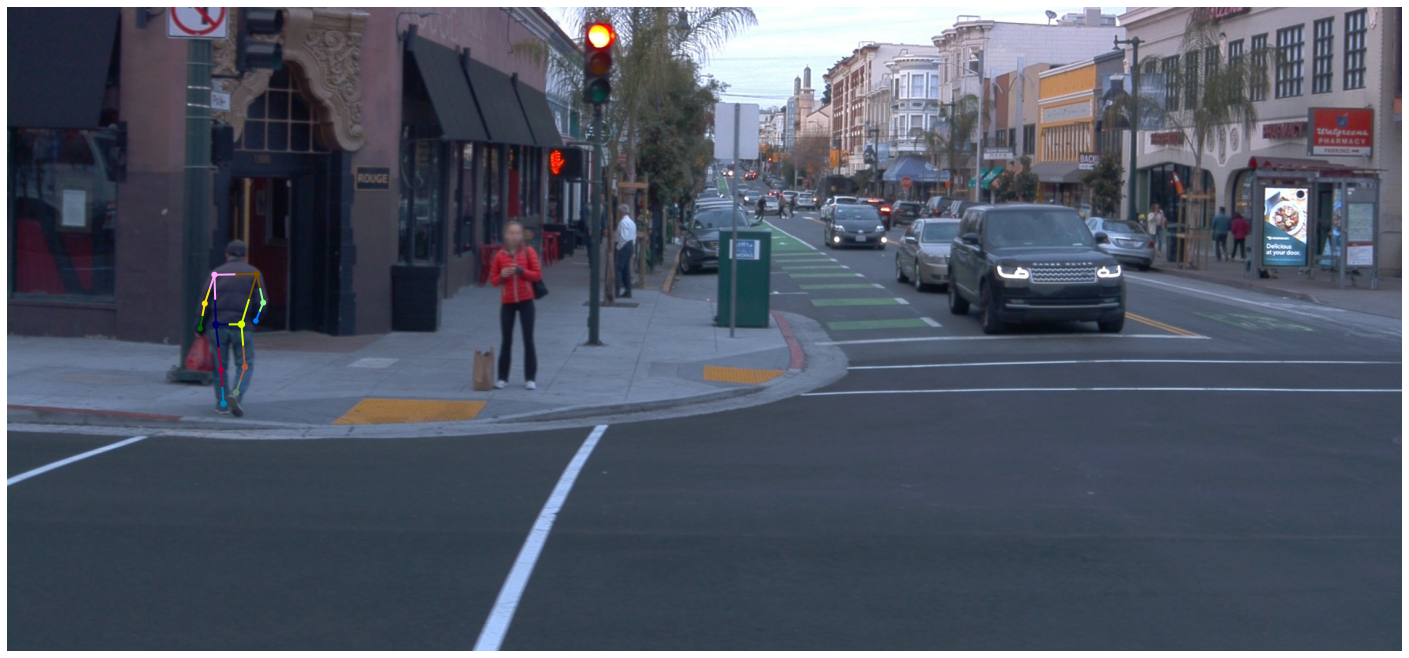

In [7]:
# display keypoints in complete image

import io
import PIL
import numpy as np
from waymo_open_dataset.utils import keypoint_draw
import matplotlib.pyplot as plt

def _imshow(ax: plt.Axes, image_np: np.ndarray):
      # image_np = cv2.copyMakeBorder(image_np, top=250, bottom=250, left=250, right=250, borderType=cv2.BORDER_CONSTANT)
  ax.imshow(image_np)
  ax.axis('off')
  ax.set_autoscale_on(False)


def _imdecode(buf: bytes) -> np.ndarray:
    with io.BytesIO(buf) as fd:
            pil = PIL.Image.open(fd)
            return np.array(pil)
        
camera_image_by_name = {i.name: i.image for i in frame.images}


image_np = _imdecode(camera_image_by_name[cam])
croped_image, cropped_camera_keypoints = keypoint_draw.crop_camera_keypoints(
    image_np,
    obj_labels.camera[cam].keypoints.keypoint,
    obj_labels.camera[cam].box,
    margin=0.3)
camera_wireframe = keypoint_draw.build_camera_wireframe(
    obj_labels.camera[cam].keypoints.keypoint)

keypoint_draw.OCCLUDED_BORDER_WIDTH = 3
_, ax = plt.subplots(frameon=False, figsize=(25, 25))
_imshow(ax, image_np)
keypoint_draw.draw_camera_wireframe(ax, camera_wireframe)


In [8]:

import matplotlib.pyplot as plt


def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  img = tf.image.decode_jpeg(camera_image.image)
  height, width, _ = img.shape
  plot_image(camera_image)
  print(f'Image height: {height}')
  print(f'Image width: {width}')

  xs = []
  ys = []
  colors = []

  for point in projected_points:
        
    if 0 <= point[0] <= width and 0 <= point[1] <= height :  
      xs.append(point[0])  # width, col
      ys.append(point[1])  # height, row
      colors.append(rgba_func(point[2]))
  plt.axis('off')
  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

def plot_image(camera_image):
    """Plot a camera image."""
    plt.figure(figsize=(20, 12))
    plt.imshow(tf.image.decode_jpeg(camera_image.image))
    plt.grid("off")
    
    
def rgba(r):
      """Generates a color based on range.

      Args:
        r: the range value of a given point.
      Returns:
        The color for a given range
      """
      c = plt.get_cmap('jet')((r % 20.0) / 20.0)
      c = list(c)
      c[-1] = 0.5  # alpha
      return c


In [9]:
frame.context

name: "5847910688643719375_180_000_200_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2060.5623623603283
  intrinsic: 2060.5623623603283
  intrinsic: 947.4602731024576
  intrinsic: 634.3692534969996
  intrinsic: 0.0362820606109964
  intrinsic: -0.3476289389978948
  intrinsic: 0.0010346643648074074
  intrinsic: -0.00029260740283121686
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999564017932523
    transform: -0.004930000027763217
    transform: 0.007930297120415031
    transform: 1.5393146754505447
    transform: 0.004850015681211909
    transform: 0.9999374967211561
    transform: 0.010073728153969801
    transform: -0.02289926109969297
    transform: -0.007979464930921549
    transform: -0.010034826892096343
    transform: 0.9999178118168822
    transform: 2.115658683271171
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  intri

In [10]:
frame.pose.transform

[0.9868528861355994, -0.16084315224276147, -0.015838607970694397, -1341.6153740009295, 0.1607278424327722, 0.9869637750817729, -0.008310676461126853, 3321.3191308957307, 0.01696884771407416, 0.0056557097651340075, 0.9998400227807992, -100.31700000000001, 0.0, 0.0, 0.0, 1.0]

In [11]:
from waymo_open_dataset.camera.ops import py_camera_model_ops
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset.utils import box_utils



range_images, camera_projections, seg_labels, range_image_top_pose = frame_utils.parse_range_image_and_camera_projection(frame)

points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)

# make list to array
points_all = np.concatenate(points, axis=0)

image = next(im for im in frame.images if im.name == cam)

#img = tf.image.decode_jpeg(image.image).numpy()
pose_tf = tf.reshape(tf.constant(frame.pose.transform, dtype=tf.float64), [4, 4])
points_world = tf.einsum('ij,nj->ni', pose_tf[:3, :3], points_all) +pose_tf[:3, 3]

cam_calib = next(c for c in frame.context.camera_calibrations if c.name == cam)
extrinsic = tf.reshape(tf.constant(cam_calib.extrinsic.transform), [4, 4])
intrinsic = tf.constant(cam_calib.intrinsic)
metadata = tf.constant([cam_calib.width, cam_calib.height, cam_calib.rolling_shutter_direction], dtype=tf.int32)
                  

# camera_image_metadata = list(image.pose.transform)
# camera_image_metadata.append(image.velocity.v_x)
# camera_image_metadata.append(image.velocity.v_y)
# camera_image_metadata.append(image.velocity.v_z)
# camera_image_metadata.append(image.velocity.w_x)
# camera_image_metadata.append(image.velocity.w_y)
# camera_image_metadata.append(image.velocity.w_z)
# camera_image_metadata.append(image.pose_timestamp)
# camera_image_metadata.append(image.shutter)
# camera_image_metadata.append(image.camera_trigger_time)
# camera_image_metadata.append(image.camera_readout_done_time)

camera_image_metadata = tf.constant([
        *image.pose.transform,
        image.velocity.v_x, image.velocity.v_y, image.velocity.v_z,
        image.velocity.w_x, image.velocity.w_y, image.velocity.w_z,
        image.pose_timestamp,
        image.shutter,
        image.camera_trigger_time,
        image.camera_readout_done_time
    ], dtype=tf.float32)


In [12]:
types = []
keypoints = []
ocllusions = []
for elm in obj_labels.laser.keypoints.keypoint:
    types.append(elm.type)
    keypoints.append((elm.keypoint_3d.location_m.x,
                     elm.keypoint_3d.location_m.y,
                     elm.keypoint_3d.location_m.z))
    ocllusions.append(elm.keypoint_3d.visibility.is_occluded)
    
keypoints = tf.constant(keypoints, dtype=tf.float64) 

keypoints_world = tf.einsum('ij,nj->ni', pose_tf[:3, :3], keypoints) + pose_tf[:3, 3]
    

In [13]:
keypoints_world = tf.cast(keypoints_world, tf.float32)


In [14]:
keypoints_world

<tf.Tensor: shape=(13, 3), dtype=float32, numpy=
array([[-1346.9056  ,  3333.8901  ,   -99.65514 ],
       [-1346.7052  ,  3334.1223  ,   -99.02154 ],
       [-1346.5792  ,  3333.9695  ,   -99.65545 ],
       [-1346.4865  ,  3334.1099  ,   -99.61224 ],
       [-1346.7522  ,  3333.9482  ,   -99.65776 ],
       [-1346.5667  ,  3334.0327  ,   -99.99273 ],
       [-1346.5417  ,  3334.033   ,   -99.2258  ],
       [-1346.5267  ,  3333.8303  ,  -100.281456],
       [-1346.7628  ,  3333.9614  ,   -99.99318 ],
       [-1346.811   ,  3334.0027  ,   -99.22378 ],
       [-1346.879   ,  3333.9172  ,   -99.46999 ],
       [-1346.7412  ,  3333.942   ,  -100.312195],
       [-1346.4535  ,  3334.0393  ,   -99.49288 ]], dtype=float32)>

In [15]:
cp_keypoints = py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata, camera_image_metadata, keypoints_world)

In [16]:
cp_keypoints

<tf.Tensor: shape=(13, 3), dtype=float32, numpy=
array([[253.32387, 435.84122,   1.     ],
       [300.665  , 336.15536,   1.     ],
       [306.423  , 436.71637,   1.     ],
       [330.05374, 428.47192,   1.     ],
       [279.83572, 436.32385,   1.     ],
       [312.27197, 487.9946 ,   1.     ],
       [317.2979 , 369.36218,   1.     ],
       [302.77792, 537.4756 ,   1.     ],
       [278.76575, 488.05954,   1.     ],
       [276.2303 , 367.95267,   1.     ],
       [259.53452, 406.80463,   1.     ],
       [279.9696 , 538.0335 ,   1.     ],
       [330.01846, 411.20734,   1.     ]], dtype=float32)>

In [17]:
from waymo_open_dataset.protos import keypoint_pb2
from waymo_open_dataset.utils import keypoint_draw

tf_keypoints = []

for index, kp in enumerate(cp_keypoints):
    cam_keypoint = keypoint_pb2.CameraKeypoint()
    cam_keypoint.type = types[index]
    cam_keypoint.keypoint_2d.location_px.x = kp[0]
    cam_keypoint.keypoint_2d.location_px.y = kp[1]
    cam_keypoint.keypoint_2d.visibility.is_occluded =  ocllusions[index]
    tf_keypoints.append(cam_keypoint)

camera_wireframe = keypoint_draw.build_camera_wireframe(
    tf_keypoints)

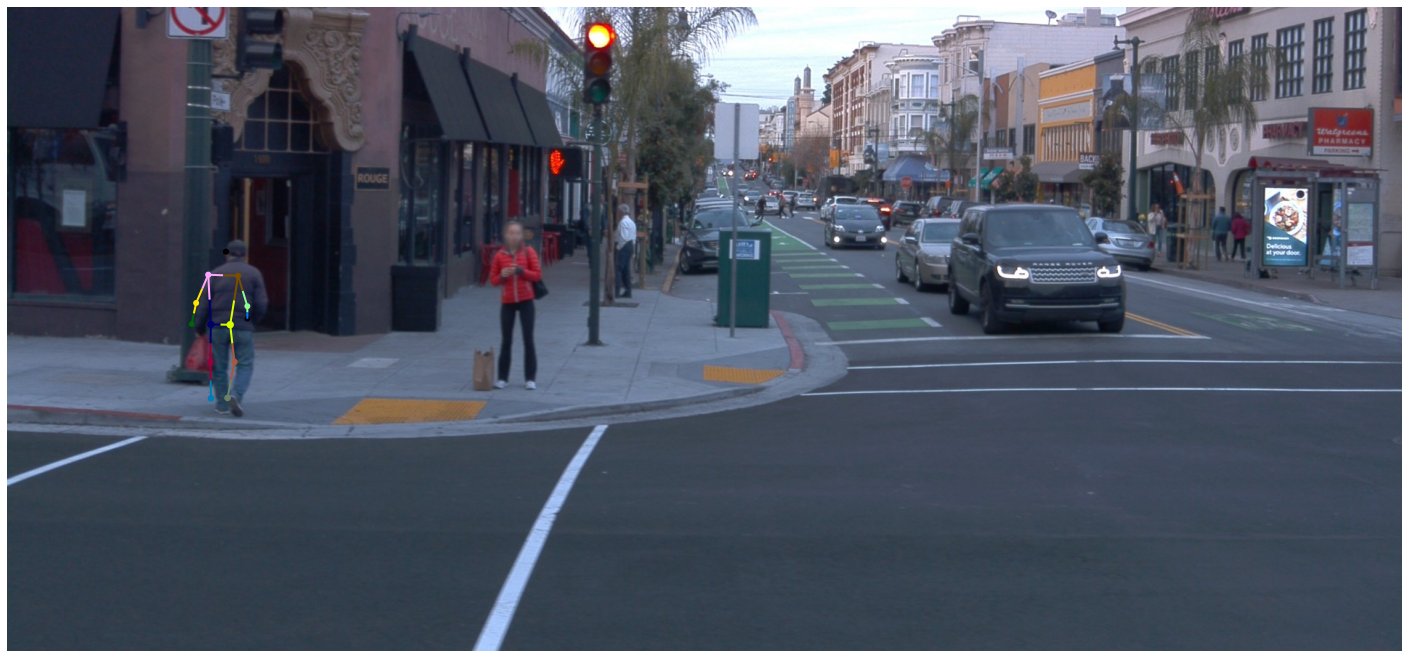

In [18]:
keypoint_draw.OCCLUDED_BORDER_WIDTH = 3
_, ax = plt.subplots(frameon=False, figsize=(25, 25))
_imshow(ax, image_np)
keypoint_draw.draw_camera_wireframe(ax, camera_wireframe)

In [19]:
cp_keypoints

<tf.Tensor: shape=(13, 3), dtype=float32, numpy=
array([[253.32387, 435.84122,   1.     ],
       [300.665  , 336.15536,   1.     ],
       [306.423  , 436.71637,   1.     ],
       [330.05374, 428.47192,   1.     ],
       [279.83572, 436.32385,   1.     ],
       [312.27197, 487.9946 ,   1.     ],
       [317.2979 , 369.36218,   1.     ],
       [302.77792, 537.4756 ,   1.     ],
       [278.76575, 488.05954,   1.     ],
       [276.2303 , 367.95267,   1.     ],
       [259.53452, 406.80463,   1.     ],
       [279.9696 , 538.0335 ,   1.     ],
       [330.01846, 411.20734,   1.     ]], dtype=float32)>

In [20]:
 valid_cp_mask = np.array(cp_keypoints[:, -1], dtype=bool)
    

In [21]:
cp_keypoints_masked = cp_keypoints[valid_cp_mask]


In [22]:
min_x = np.min(cp_keypoints_masked[:, 0])
max_x = np.max(cp_keypoints_masked[:, 0])
min_y = np.min(cp_keypoints_masked[:, 1])
max_y = np.max(cp_keypoints_masked[:, 1])

In [23]:
keypoints_projected = np.empty(cp_keypoints[:, :2].shape)
keypoints_projected[:, 0] = cp_keypoints[:, 0] - min_x
keypoints_projected[:, 1] = cp_keypoints[:, 1] - min_y

In [24]:
keypoints_projected

array([[  0.        ,  99.68585205],
       [ 47.34114075,   0.        ],
       [ 53.09913635, 100.56100464],
       [ 76.72987366,  92.31655884],
       [ 26.51185608, 100.16848755],
       [ 58.94810486, 151.8392334 ],
       [ 63.9740448 ,  33.20681763],
       [ 49.45405579, 201.32022095],
       [ 25.44187927, 151.9041748 ],
       [ 22.90641785,  31.79730225],
       [  6.21064758,  70.64926147],
       [ 26.64573669, 201.87814331],
       [ 76.69459534,  75.05197144]])

In [25]:
92.1439209-48.21074977


43.93317113

In [26]:
keypoints_projected[:,0] -  43.93317113

array([-43.93317113,   3.40796962,   9.16596522,  32.79670253,
       -17.42131505,  15.01493373,  20.04087367,   5.52088466,
       -18.49129186, -21.02675328, -37.72252355, -17.28743444,
        32.76142421])

In [27]:
cp_points_all = py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata, camera_image_metadata, tf.cast(points_world, tf.float32))


distance = tf.norm(points_all, axis=-1, keepdims=True)

mask = tf.equal(cp_points_all[..., -1], 1)
distance = tf.cast(tf.gather_nd(distance, tf.where(mask)), dtype=tf.float64)
valid_points = tf.cast(tf.gather_nd(cp_points_all, tf.where(mask)), dtype=tf.float64)[:,:2]
print(valid_points.shape)

points = tf.concat([valid_points, distance], axis=-1)



(35036, 2)


In [28]:
cp_points[1]

array([[   1,  424,  252,    0,    0,    0],
       [   1,  505,  258,    0,    0,    0],
       [   1, 1840,  292,    3,  136,  294],
       ...,
       [   0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0]], dtype=int32)

Image height: 886
Image width: 1920


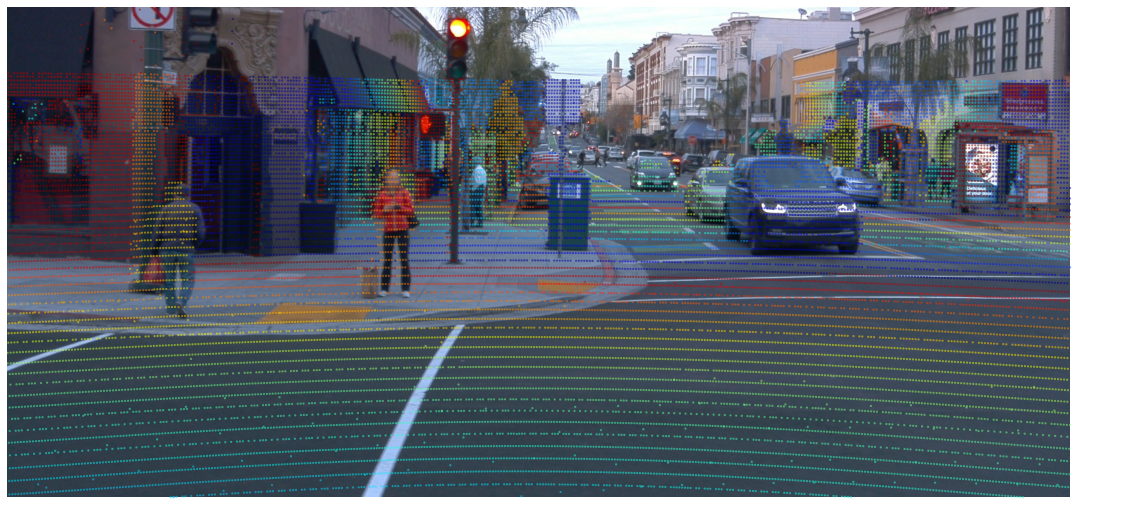

In [29]:

plot_points_on_image(points,
                     image, rgba, point_size=5.0)
plt.savefig('lidar_projections.pdf',  dpi=1000)

In [30]:
plt.savefig('lidar_projections.pdf',  dpi=1000)

<Figure size 432x288 with 0 Axes>

In [31]:
def project_point(point, camera_calibration):
    # vehicle frame to camera sensor frame.
  extrinsic = tf.reshape(camera_calibration.extrinsic.transform, [4, 4])
  vehicle_to_sensor = tf.linalg.inv(extrinsic)
  point1 = point
  point1.append(1)
  point_camera_frame = tf.einsum('ij,j->i', vehicle_to_sensor, tf.constant(point1, dtype=tf.float32))
  u_d = - point_camera_frame[1] / point_camera_frame[0]
  v_d = - point_camera_frame[2] / point_camera_frame[0]
 
  # add distortion model here if you'd like.
  f_u = camera_calibration.intrinsic[0];
  f_v = camera_calibration.intrinsic[1];
  c_u = camera_calibration.intrinsic[2];
  c_v = camera_calibration.intrinsic[3];
  u_d = u_d * f_u + c_u;
  v_d = v_d * f_v + c_v;
  
  point1.pop(-1)

  return [u_d.numpy(), v_d.numpy()]

In [32]:
from tqdm import tqdm
points_list = []
for point in tqdm(points_all):

    x, y = project_point(list(point), cam_calib)
    points_list.append([x,y])
    
    
    
    

  5%|▍         | 8100/168778 [00:05<01:41, 1579.23it/s]


KeyboardInterrupt: 

Image height: 886
Image width: 1920


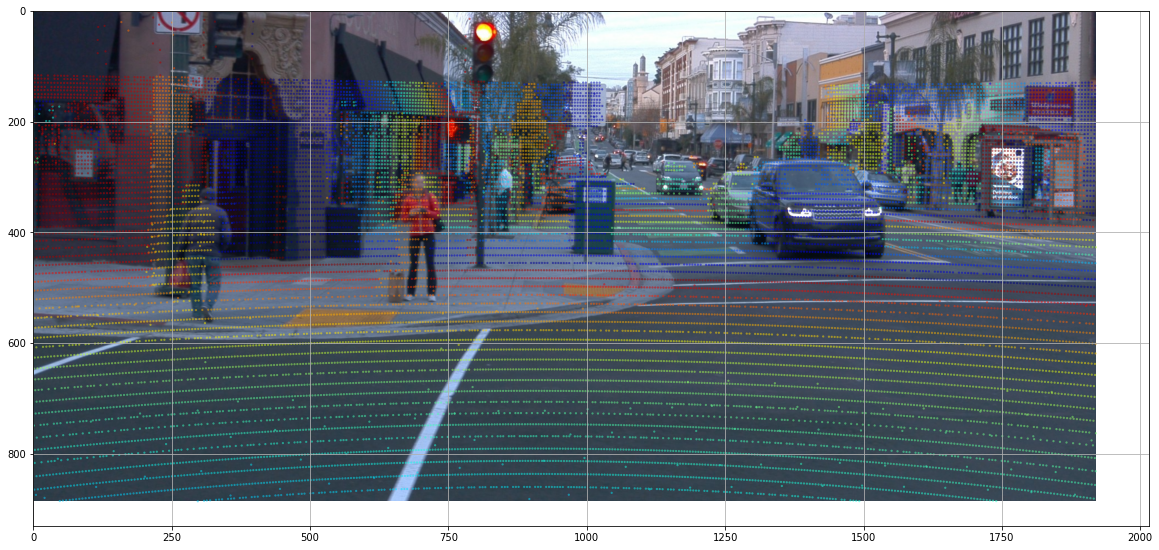

In [ ]:
proj_points_tf = tf.constant(points_list, dtype=tf.float32)
valid_points_tf = tf.cast(tf.gather_nd(proj_points_tf, tf.where(mask)), dtype=tf.float64)[:,:2]
points_tf = tf.concat([valid_points_tf, distance], axis=-1)
plot_points_on_image(points_tf,
                    image, rgba, point_size=5.0)